In [57]:
import os
import pandas as pd
import geopandas as gpd
import psycopg2
import sqlalchemy as db
import matplotlib.pyplot as plt
import descartes
import platform
import mapclassify as mc
import json
from datetime import datetime


In [58]:
# Display versions for troubleshooting
pd.__version__, gpd.__version__, platform.python_version()

('0.25.1', '0.6.1', '3.7.4')

In [59]:
# connect to database 
from sqlalchemy import create_engine
POSTGRES_ADDRESS = 'localhost'
POSTGRES_PORT = '5432'
POSTGRES_USERNAME = 'nathanthomas'
POSTGRES_PASSWORD = 'cashflow'
POSTGRES_DBNAME = 'conditions'
postgres_str = (f'postgresql://{POSTGRES_USERNAME}:{POSTGRES_PASSWORD}@{POSTGRES_ADDRESS}:{POSTGRES_PORT}/{POSTGRES_DBNAME}')

# Create the connection
cnx = create_engine(postgres_str)


In [60]:
conditions = pd.read_sql_query('SELECT * FROM conditions_map_conditions;', cnx)
# conditions.head()

In [61]:
conditions = conditions[['name', 'state']]
conditions_map_data = conditions.rename(index=int, columns={'name':'CONDITION', 'state':'STATE_ABBR'})
# conditions_map_data.head()

In [62]:
states= gpd.read_file('/Users/nathanthomas/turing/4module/projects/mymd2/testing_testing/Data/states.shp')
states_formatted = states[['STATE_ABBR', 'geometry']]
# Remove Hawaii and Alaska
usa = states_formatted[~states_formatted.STATE_ABBR.isin(['HI', 'AK'])]
# usa.head()

In [63]:
merged = usa.set_index('STATE_ABBR').join(conditions_map_data.set_index('STATE_ABBR'))
# merged.head()

In [64]:
grpd = merged.groupby(['STATE_ABBR','CONDITION']).size().to_frame('NUM').reset_index()
# grpd.head()

In [65]:
def fetch_map_data(condition):
    user_condition = grpd[grpd.CONDITION == f'{condition}']
    joined = usa.set_index('STATE_ABBR').join(user_condition.set_index('STATE_ABBR')).reset_index()
    values = {'CONDITION': 'no record', 'NUM': 0}
    rtp = joined.fillna(value = values)
    return rtp
    

In [66]:
def render_map(condition):
    map_data = fetch_map_data(condition)
    ax = map_data.dropna().plot(column=map_data.NUM, cmap =    
                                 'Blues', 
                                 figsize=(15,9),   
                                 scheme='natural_breaks', k=6, 
                                 legend=True,
                                 edgecolor='black', 
                                 linewidth=0.8);
    ax.axis('off')
    ax.set_title(f'MeMD {condition.capitalize()} Diagnosis Across the US', fontdict={'fontsize': '35', 'fontweight' : '5'})
    ax.get_legend().set_bbox_to_anchor((.22,.29))
    current_time = datetime.now()
    date = current_time.strftime('%m-%d-%Y')
    ax.annotate(f'This map is a representation of {condition} diagnosis across the US among MeMD users only. Last Updated: {date}', xy=(0.1, .08),  xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')
    ax.get_figure()
    return ax

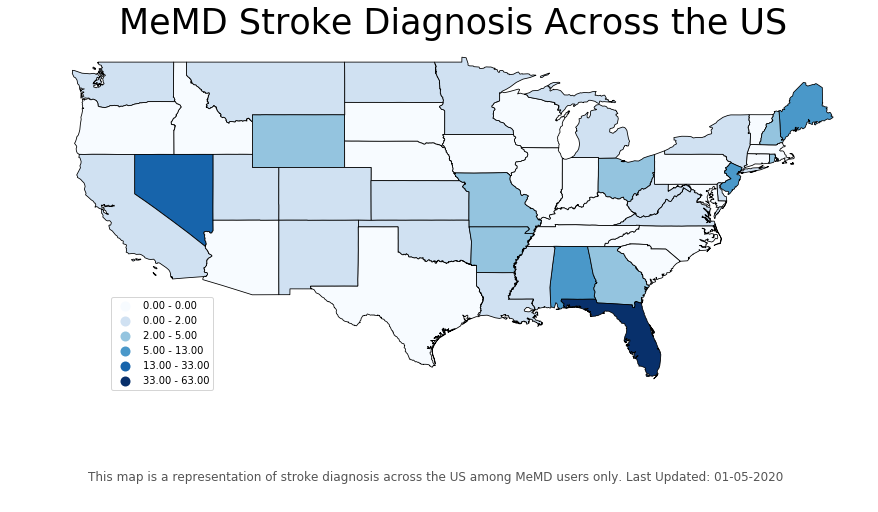

In [67]:
render_map('stroke')

In [92]:
# # GET /conditions_map
# render_map('stroke')

